In [2]:
# VOOR XGB BOOST INDIEN CODE NIET RUNT LOKAAL, COMMENT  DEZE 3 LIJNEN DAN

import os

# VERANDER HET PATH NAAR JOU EIGEN LOKAAL PATH INDIEN NODIG
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.metrics import confusion_matrix, mean_squared_error,precision_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import f1_score
# ALS XGBOOST NIET GEINSTALLEER IS COMMENT DAN VOLGENDE 3 LIJNEN
####
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree
####
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import ipywidgets as widgets
plt.style.use('fivethirtyeight')
pd.options.display.max_columns = 30

<h1>Pandas performance optimaliseren</h1>

In [4]:
# Csv file inlezen in een python dataframe
df = pd.read_csv('data/shot_logs.csv')
df20 = df.copy()


<h3>Gewone loops in pandas</h3>

In [5]:
# functie die gewoon doe alle rows afgaat en de waarde in een nieuwe lijst steekt
def manuele_loop(df):
    test_list = []
    for i in range(0, len(df)):
        d = df.iloc[i]['SHOT_CLOCK']
        test_list.append(d)
    return test_list

In [6]:

# Maneuele loop functie runnen en timen
result_gewoon = %timeit -o df['testkolom'] = manuele_loop(df)


1 loop, best of 3: 17.9 s per loop


<h3>Loopen met iterrows()</h3>

In [7]:
result_iterrows = %timeit -o test_list = [df['SHOT_CLOCK'] for index, row in df.iterrows()]

1 loop, best of 3: 5.52 s per loop


<h3>Loopen met de apply() methode</h3>

In [8]:
result_apply = %timeit -o df['testkolom'] = df.apply(lambda row: df['SHOT_CLOCK'])

10 loops, best of 3: 76.8 ms per loop


<h3>Vectoriseren over pandas series (executie over een volledige array)</h3>

In [9]:
result_vector = %timeit -o df['testkolom'] = df['SHOT_CLOCK']

1000 loops, best of 3: 206 µs per loop


In [10]:
result_gewoon2 = round(result_gewoon.best * 100,4)
result_iterrows2 = round(result_iterrows.best * 100,4)
result_apply2 = round(result_apply.best * 100,4)
result_vector2 = round(result_vector.best * 100,4)
sales = [("TYPE VAN LOOP", ["Manuele loop", "iterrows loop", "apply loops", "Vectoriseren"]),
         ("UITVOERSNELHEID", [result_gewoon2, result_iterrows2, result_apply2, result_vector2]),
         ("IMPROVEMENT", [" ", "x" + str(round(result_gewoon2 / result_iterrows2)),"x" + str(round(result_iterrows2 / result_apply2)),"x" + str(round(result_apply2 / result_vector2))])
         ]
df2 = pd.DataFrame.from_items(sales)
df2

,TYPE VAN LOOP,UITVOERSNELHEID,IMPROVEMENT
0,Manuele loop,1785.1457,
1,iterrows loop,551.7563,x3
2,apply loops,7.6773,x72
3,Vectoriseren,0.0206,x373


<h1>De dataset opkuisen</h1>

In [11]:
# headers van df.columns
#'GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER',
#'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
#'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSEST_DEFENDER',
#'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS',
#'player_name', 'player_id'
df = pd.read_csv('data/shot_logs.csv')
df.columns = map(str.upper, df.columns)
df.describe()


,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,PLAYER_ID
count,1.280690e+05,128069.000000,128069.000000,128069.000000,122502.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000
mean,2.140045e+07,0.208723,6.506899,2.469427,12.453344,2.023355,2.765901,13.571504,2.264670,159038.487284,4.123015,0.452139,0.997314,157238.251247
std,2.578773e+02,13.233267,4.713260,1.139919,5.763265,3.477760,3.043682,8.888964,0.441159,78791.172947,2.756446,0.497706,1.130978,79362.389336
min,2.140000e+07,-53.000000,1.000000,1.000000,0.000000,0.000000,-163.600000,0.000000,2.000000,708.000000,0.000000,0.000000,0.000000,708.000000
25%,2.140023e+07,-8.000000,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.000000,101249.000000,2.300000,0.000000,0.000000,101162.000000
50%,2.140045e+07,1.000000,5.000000,2.000000,12.300000,1.000000,1.600000,13.700000,2.000000,201949.000000,3.700000,0.000000,0.000000,201939.000000
75%,2.140067e+07,9.000000,9.000000,3.000000,16.675000,2.000000,3.700000,22.500000,3.000000,203079.000000,5.300000,1.000000,2.000000,202704.000000
max,2.140091e+07,53.000000,38.000000,7.000000,24.000000,32.000000,24.900000,47.200000,3.000000,530027.000000,53.200000,1.000000,3.000000,204060.000000


<h3>Null values in dataset</h3>

In [12]:
# Check welke kolommen null values bevatten
df.isnull().sum()

GAME_ID                          0
MATCHUP                          0
LOCATION                         0
W                                0
FINAL_MARGIN                     0
SHOT_NUMBER                      0
PERIOD                           0
GAME_CLOCK                       0
SHOT_CLOCK                    5567
DRIBBLES                         0
TOUCH_TIME                       0
SHOT_DIST                        0
PTS_TYPE                         0
SHOT_RESULT                      0
CLOSEST_DEFENDER                 0
CLOSEST_DEFENDER_PLAYER_ID       0
CLOSE_DEF_DIST                   0
FGM                              0
PTS                              0
PLAYER_NAME                      0
PLAYER_ID                        0
dtype: int64

In [13]:
# Totaal aantal rijen waar SHOT_CLICK = NaN en hoeveel % vd dataset
shotclock_nan = len (df[df['SHOT_CLOCK'].isnull()])
print("totaal aantal rijen in SHOT_CLOCK met NaN: " + str(shotclock_nan))
print ("Aaantal % van de SHOT_CLOCK kolom NaN: " + str(round(float(len (df[df.SHOT_CLOCK.isnull()==True]))/float(len (df)),2)*100),'%')

totaal aantal rijen in SHOT_CLOCK met NaN: 5567
Aaantal % van de SHOT_CLOCK kolom NaN: 4.0 %


In [14]:
# Theorie shotclock = NaN?
# In basketbal wanneer game clock < 24 seconden, wordt de shotclock afgezet, dit zou dus kunnen leiden tot deze values.
# Om na te gaan of dit werkelijk de oorzaak is gaan we 3 tests doen:
#      1. Kijken of er degelijk NaN waarden zijn als game clock < 24 seconden
#      2. Kijken of er nog altijd NaN waarden zijn als game clock > 24 seconden
#      3. Kijken of er instanties bestaan waarbij de shotclock valid time heeft en game clock < 24

nan_under_24 = len(df[(df['GAME_CLOCK'] <= '0:24') & (df['SHOT_CLOCK'].isnull())])
nan_over_24 = len(df[(df['GAME_CLOCK'] > '0:24') & (df['SHOT_CLOCK'].isnull())])
valid_under_24 = len(df[(df['GAME_CLOCK'] <= '0:24') & (~df['SHOT_CLOCK'].isnull())])

print("Aantal NaN als game clock <= 24 seconden: " + str(nan_under_24))
print("Aantal NaN als game clock > 24 seconden: " + str(nan_over_24))
print("Aantal instanties waar shotclock  is valid time en game clock < 24: " + str(valid_under_24))

# Conclusie: Er is geen logische verklaring voor shotclock = NaN.
# Aangezien bij game clock < 24, de shot clock zowel NaN kan zijn, als een valid time.

Aantal NaN als game clock <= 24 seconden: 3554
Aantal NaN als game clock > 24 seconden: 2013
Aantal instanties waar shotclock  is valid time en game clock < 24: 2118


In [15]:
# Rows verwijderen waar shot clock = NaN
nan=float('nan')
df=df[~np.isnan(df['SHOT_CLOCK'])]

<h3>Fouten & aanpassingen in dataset</h3>

In [16]:
# PTS_TYPE = 3 en SHOT_DIST < 22, 22 feet is de kortste afstand in nba voor een 3 punter, toch zijn er instanties waar
# een speler 3 punten scoort en toch SHOT_DIST < 22 heeft.
aantal_foute_3punters = len(df[(df['SHOT_DIST'] < 22) & (df['PTS_TYPE'] == 3)])
print("Aantal rows waarin een 3 punter een te korte afstand heeft: " + str(aantal_foute_3punters))
print ("Aantal procent negatieve touch value: " + str(round(aantal_foute_3punters/float(len (df)),2)*100),'%')

Aantal rows waarin een 3 punter een te korte afstand heeft: 778
Aantal procent negatieve touch value: 1.0 %


In [17]:
# https://youtu.be/InDis_QY2X4?t=186 Link naar de game waarbij klay de 3 punter shot
df[(df['GAME_ID'] == 21400382) & (df['SHOT_DIST'] < 22) & (df['PTS_TYPE'] == 3)]

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,PLAYER_NAME,PLAYER_ID
15593,21400382,"DEC 18, 2014 - GSW vs. OKC",H,W,5,6,2,3:28,21.4,0,1.2,20.9,3,made,"Jones, Perry",203103,5.4,1,3,klay thompson,202691


In [18]:
# Overal waar shot distance < 22 feet maar toch een 3 punter is, gaan we shot_dist op 9999 zetten
df.loc[(df['SHOT_DIST'] < 22) & (df['PTS_TYPE'] == 3), 'SHOT_DIST'] = 22.0

In [19]:
# Touch time is in sommige gevallen negatief
touch_neg = len (df[df['TOUCH_TIME']<0])
print ("Aantal negatieve touch value: " + str(touch_neg))
print ("Aantal procent negatieve touch value: " + str(round(len (df[df['TOUCH_TIME']<0])/float(len (df)),3)*100),'%')

Aantal negatieve touch value: 299
Aantal procent negatieve touch value: 0.2 %


In [20]:
#Enkel de rows overhouden waar touchtime > 0
df=df[df['TOUCH_TIME']>0]

In [21]:
# MATCHUP kolom bevat veel data dat eigenlijk kan opgesplitst worden (datum / thuisteam / uitteam)

# splits datum voor datum kolom
def datum_split(rows):
    
    (date,teams)=rows.split('-')
    date=date.strip()
    
    return date

# splits thuis team adhv @ of vs voor thuis team kolom
def thuis_team_split(rows):
    (date,teams) = rows.split('-')
    if '@' in teams:
        (team1, team2) = teams.split('@')
    if 'vs.' in teams:
        (team2, team1) = teams.split('vs.')

    team2 = team2.strip()

    return(team2)

# splits uit team adhv @ of vs voor uit team kolom
def uit_team_split(rows):
    (date,teams) = rows.split('-')
    if '@' in teams:
        (team2, team1) = teams.split('@')
    if 'vs.' in teams:
        (team1, team2) = teams.split('vs.')

    team2 = team2.strip()

    return(team2)
           
# defenieer winning team adhv @ of vs en de W kolom voor de winning team kolom
def winning_team(rows):
    (date,teams) = rows['MATCHUP'].split('-')
    if '@' in teams:
        (team1, team2) = teams.split('@')
        if  rows['W'] == 'L':
            winning_team = team2.strip()
        else:
            winning_team = team1.strip()
            
    if 'vs.' in teams:
        (team2, team1) = teams.split('vs.')
        if rows['W'] == 'L':
            winning_team = team1.strip()
        else:
            winning_team = team2.strip()
    return winning_team

In [22]:
%%timeit
df['DATUM']=df['MATCHUP'].apply(datum_split)
df['DATUM']=df['DATUM'].apply(pd.to_datetime)
df['THUIS_TEAM']=df['MATCHUP'].apply(thuis_team_split)
df['UIT_TEAM']=df['MATCHUP'].apply(uit_team_split)
# axis = 1 MOET ERBIJ!!!! specifieert dat het over rijen moet gaan en niet over kolommen
df['WIN_TEAM']=df.apply(winning_team, axis=1)
df.head()

1 loop, best of 3: 29.2 s per loop


<h1>Analyse vd dataset adhv graphs</h1>

<h3>Thuis / Uit voordeel voor winstpercentage van ploegen</h3>

In [23]:
# BIG PITFALL IN DE DATASET --> elke match staat er eigenlijk 2x in:
#                              1. 1x als Uit_ploeg: @ thuis_ploeg
#                              2. 1x als thuis_ploeg vs uit_ploeg 
# Dit is gewoon 1 match, maar staat er dubbel in om aan te geven bij welk team speler eigenlijk hoort.

# Elke matchup er maar 1x in laten voorkomen


# Array van alle teams
all_teams = sorted((df['THUIS_TEAM'].unique()))

def home_away_specific_team(team):
    # THUIS
    df4 = df.drop_duplicates(['MATCHUP'])
    df4 = df4[(df4['THUIS_TEAM'] == str(team))]
    df4 = df4.drop_duplicates(subset=['DATUM', 'THUIS_TEAM', 'UIT_TEAM'])
    home_wins = len(df4[(df4['THUIS_TEAM'] == team) & (df4['WIN_TEAM'] == team)])  
    home_losses = len(df4[(df4['THUIS_TEAM'] == team) & (df4['WIN_TEAM'] != team)]) 
    
    # UIT
    df5 = df.drop_duplicates(['MATCHUP'])
    df5 = df5[(df5['UIT_TEAM'] == str(team))]
    df5 = df5.drop_duplicates(subset=['DATUM', 'THUIS_TEAM', 'UIT_TEAM'])  
    away_wins = len(df5[(df5['UIT_TEAM'] == team) & (df5['WIN_TEAM'] == team)]) 
    away_losses = len(df5[(df5['UIT_TEAM'] == team) & (df5['WIN_TEAM'] != team)]) 
    dict = {
            'home_losses':  home_losses,
            'home_wins': home_wins,
            'away_losses': away_losses,
            'away_wins': away_wins
           }

    return dict


In [24]:
# Maakt automatisch percentage van de value doorgegeven (nodig om value EN percent te tonen in pie chart)
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

# Functie die de pie charts opstelt, roept ook de home_away_specific player functie aan om deze door te geven aan de pie chart
def make_pie_teams(team):
    dict = home_away_specific_team(team)
    labels = 'Winst', 'Verlies'
    values_home = [dict['home_wins'],dict['home_losses']]
    values_away = [dict['away_wins'],dict['away_losses']]
    
    # Om de pie charts naast een te krijgen + op figure t zetten
    fig1, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    # De 2 pies
    ax1.pie(values_home, labels=labels, autopct=make_autopct(values_home), shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax2.pie(values_away, labels=labels, autopct=make_autopct(values_away), shadow=True, startangle=90)
    ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Titels van pies
    ax1.set_title('Winst/verlies %\n THUIS')
    ax2.set_title('Winst/verlies %\n UIT')
    
    # Pies niet laten overlappen (waarden zo laten staan, anders veel geknoei)
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0, right=1.3, hspace=0.5,
                    wspace=15)
    
    # Pies groter maken
    fig = plt.gcf()
    fig.set_size_inches(6,6)
    
    # Show de plots
    plt.show()
    

In [25]:
interact(make_pie_teams,team = all_teams)

<function __main__.make_pie_teams>

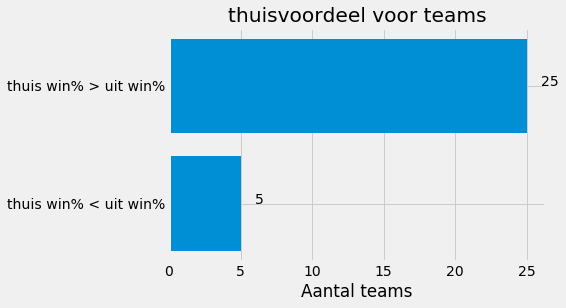

In [26]:
# THUIS UIT WIN LOS
# https://matplotlib.org/examples/pylab_examples/bar_stacked.html
# https://matplotlib.org/examples/api/barchart_demo.html

# Counter voor teams te tellen die meer/minder/gelijk thuis winnen
counter_home = 0
counter_away = 0
counter_even = 0

# Counter op laten tellen in for loop
for team in all_teams:
    dict = home_away_specific_team(team)
    total_home = sum([dict['home_losses'], dict['home_wins']])
    total_away = sum([dict['away_losses'], dict['away_wins']])
    perc_win_home = int((round(dict['home_wins']*total_home)*100.0))
    perc_win_away = int((round(dict['away_wins']*total_away)*100.0))
    
    if perc_win_home > perc_win_away:
        counter_home += 1
    elif perc_win_home < perc_win_away:
        counter_away += 1
    else: 
        counter_even += 1

# Horizontale barchart opmaken        
fig, ax = plt.subplots()
labels = 'thuis win% > uit win%', 'thuis win% < uit win%'
y_pos = np.arange(len(labels))
performance = [counter_home, counter_away]

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis() 
ax.set_xlabel('Aantal teams')
ax.set_title('thuisvoordeel voor teams')
# values naast bar (v+3 is afstand tot bar, i = hoogte)
for i, v in enumerate(performance):
    ax.text(v + 1, i, str(v), color='black')

plt.show()


<h3>Thuis / Uit voordeel voor shotpercentage van spelers</h3>

In [27]:
# HOME/AWAY INVLOED OP SHOT ??
# BEST/WORST CLUTCH TEAMS/SHOOTERS?
# SPOT UP SHOOTER VS NON SPOT UP SHOOTER

# Array van alle spelers (uniek)
all_players = sorted((df['PLAYER_NAME'].unique()))

# Functie die een playernaam ontvangt en hiervoor de percentage gemiste/gemaakte worpen in thuis/uit wedstrijden teruggeeft
def home_away_specific_player(playername):
    df3 = df[(df['PLAYER_NAME'] == str(playername))]
    obj = df3.groupby(['LOCATION', 'SHOT_RESULT']).size()
    
    dict = {
            'made_away': obj[0],
            'missed_away': obj[1],
            'made_home': obj[2],
            'missed_home': obj[3]
           }

    return dict

In [28]:
# Maakt automatisch percentage van de value doorgegeven (nodig om value EN percent te tonen in pie chart)
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

# Functie die de pie charts opstelt, roept ook de home_away_specific player functie aan om deze door te geven aan de pie chart
def make_pie_shots(playername):
    dict = home_away_specific_player(playername)
    labels = 'Gescoord', 'Gemist'
    values_home = [dict['made_home'],dict['missed_home']]
    values_away = [dict['made_away'], dict['missed_away']]
    
    # Om de pie charts naast een te krijgen + op figure t zetten
    fig1, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    # De 2 pies
    ax1.pie(values_home, labels=labels, autopct=make_autopct(values_home), shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax2.pie(values_away, labels=labels, autopct=make_autopct(values_away), shadow=True, startangle=90)
    ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Titels van pies
    ax1.set_title('shot % \n THUIS')
    ax2.set_title('shot % \n UIT')
    
    # Pies niet laten overlappen (waarden zo laten staan, anders veel geknoei)
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0, right=1.3, hspace=0.5,
                    wspace=15)
    
    # Pies groter maken
    fig = plt.gcf()
    fig.set_size_inches(6,6)
    
    # Show de plots
    plt.show()
    
    

In [29]:
interact(make_pie_shots,playername = all_players)

<function __main__.make_pie_shots>

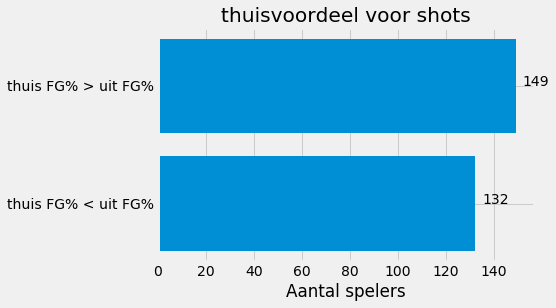

In [30]:
# Counter voor spelers te tellen die beter shotten thuis/uit of gelijk
counter_home = 0
counter_away = 0
counter_even = 0

# Counter op laten tellen in for loop
for player in all_players:
    dict = home_away_specific_player(player)
    total_home = sum([dict['made_home'],dict['missed_home']])
    total_away = sum([dict['made_away'], dict['missed_away']])
    perc_made_home = int((round(dict['made_home']*total_home)*100.0))
    perc_made_away = int((round(dict['made_away']*total_away)*100.0))
    
    if perc_made_home > perc_made_away:
        counter_home += 1
    elif perc_made_home < perc_made_away:
        counter_away += 1

# Horizontale barchart opmaken        
fig, ax = plt.subplots()
labels = 'thuis FG% > uit FG%', 'thuis FG% < uit FG%'
y_pos = np.arange(len(labels))
performance = [counter_home, counter_away]

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis() 
ax.set_xlabel('Aantal spelers')
ax.set_title('thuisvoordeel voor shots')
# values naast bar (v+3 is afstand tot bar, i = hoogte)
for i, v in enumerate(performance):
    ax.text(v + 3, i, str(v), color='black')

plt.show()

<h3>Welke andere variabelen beinvloeden het shot percentage</h3>

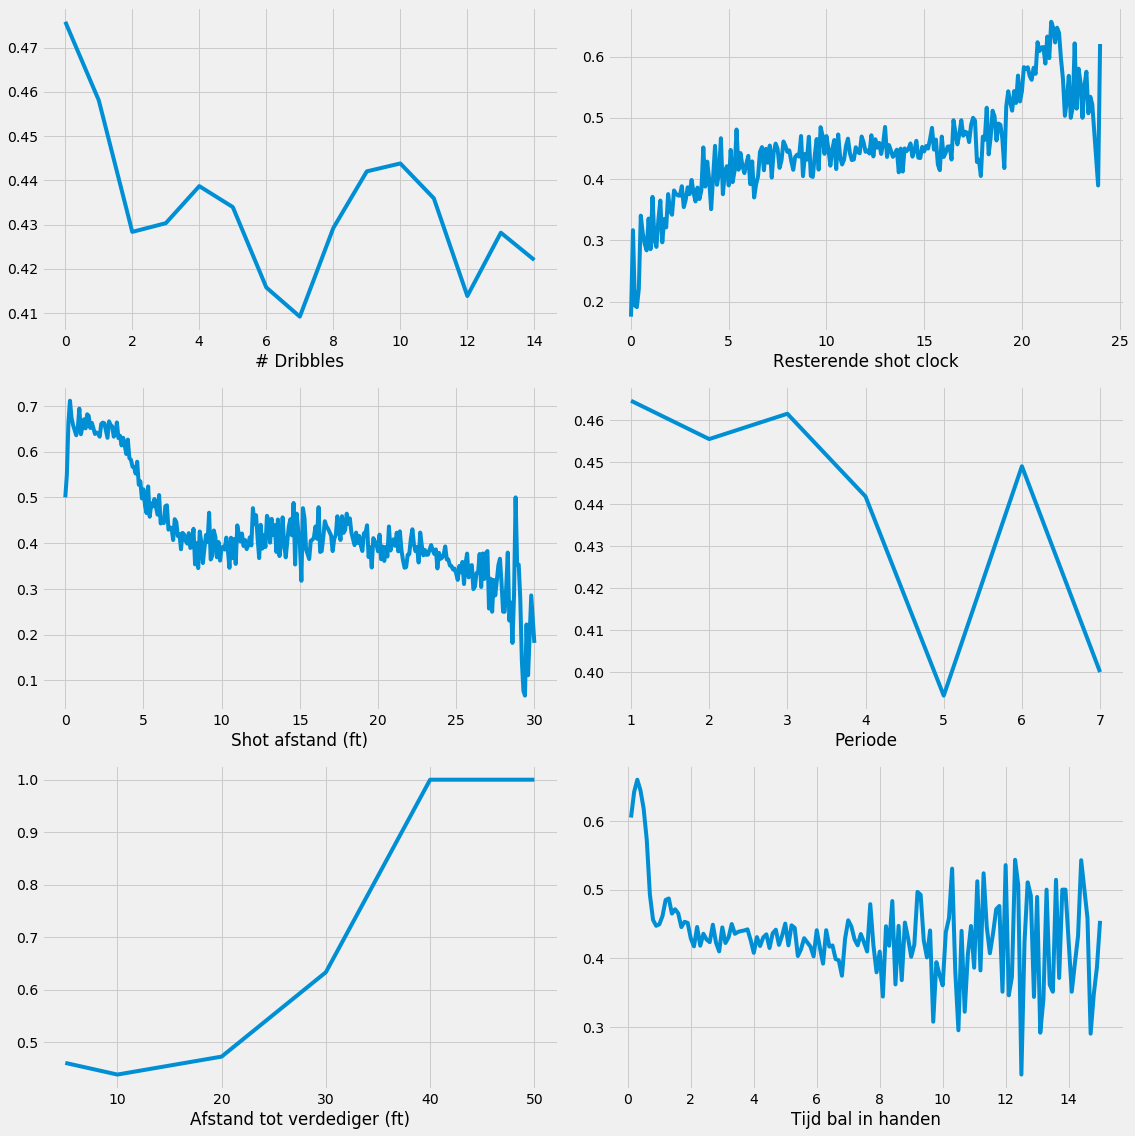

In [31]:
dribbles = df[df['DRIBBLES'] < 15].groupby('DRIBBLES')['SHOT_RESULT'].value_counts(normalize=True)
dribbles = dribbles.loc[:, 'made']

shot_clock = df[df['SHOT_CLOCK'] <= 24].groupby('SHOT_CLOCK')['SHOT_RESULT'].value_counts(normalize=True)
shot_clock = shot_clock.loc[:, 'made']

shot_dist = df[df['SHOT_DIST'] <= 30].groupby('SHOT_DIST')['SHOT_RESULT'].value_counts(normalize=True)
shot_dist = shot_dist.loc[:, 'made']

period = df[df['PERIOD'] <= 7].groupby('PERIOD')['SHOT_RESULT'].value_counts(normalize=True)
period = period.loc[:, 'made']

defender_dist = df[df['CLOSE_DEF_DIST'] <= 20].groupby('CLOSE_DEF_DIST')['SHOT_RESULT'].value_counts(normalize=True)
defender_dist = defender_dist.loc[:, 'made']

touch_time = df[df['TOUCH_TIME'] <= 15].groupby('TOUCH_TIME')['SHOT_RESULT'].value_counts(normalize=True)
touch_time = touch_time.loc[:, 'made']

distances = [0,5,10,20,30,40,50]

defender_dist = [(df[np.logical_and(np.logical_and(df['CLOSE_DEF_DIST']>distances[i-1],df['CLOSE_DEF_DIST']<distances[i] ), 
df['FGM']==1)  ].size/df[np.logical_and(df['CLOSE_DEF_DIST']>distances[i-1],
df['CLOSE_DEF_DIST']<distances[i] )  ].size)    
for i in range(1,len(distances))]
defender_dist_lambda = pd.Series(defender_dist, index = distances[1:len(distances)])

fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(3, 2, 1)
ax2 = fig.add_subplot(3, 2, 2)
ax3 = fig.add_subplot(3, 2, 3)
ax4 = fig.add_subplot(3, 2, 4)
ax5 = fig.add_subplot(3, 2, 5)
ax6 = fig.add_subplot(3, 2, 6)

ax1.plot(dribbles)
ax2.plot(shot_clock)
ax3.plot(shot_dist)
ax4.plot(period)
ax5.plot(defender_dist_lambda)
ax6.plot(touch_time)
ax1.set_xlabel('# Dribbles')
ax2.set_xlabel('Resterende shot clock')
ax3.set_xlabel('Shot afstand (ft)')
ax4.set_xlabel('Periode')
ax5.set_xlabel('Afstand tot verdediger (ft)')
ax6.set_xlabel('Tijd bal in handen')
plt.tight_layout()
plt.show()


<h1>Predictions & Machine learning | RFC vs XGB</h1>

<h3>Random Forest Classifier</h3>

In [86]:
# tutorial over voorspelling met RFC
# : http://www.agcross.com/blog/2015/02/05/random-forests-in-python-with-scikit-learn/
# https://www.kdnuggets.com/faq/precision-recall.html
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
train, test = df[df['is_train']==True], df[df['is_train']==False]
features = df.columns[[6,8,9,10,11,15]]
values = df['SHOT_RESULT'].unique()
forest = RFC(n_jobs=2,n_estimators=200)
y, _ = pd.factorize(train['SHOT_RESULT'])
forest.fit(train[features], y)
preds = values[forest.predict(test[features])]
confusion_tabel = pd.crosstab(index=test['SHOT_RESULT'], columns=preds, rownames=['actual'], colnames=['preds'])


total = confusion_tabel['made']['made'] + confusion_tabel['missed']['missed'] + confusion_tabel['made']['missed'] + confusion_tabel['missed']['made']
total_pred_correct = confusion_tabel['made']['made'] + confusion_tabel['missed']['missed']
# total_pred_made = confusion_tabel['made']['made'] + confusion_tabel['made']['missed']
# total_pred_made_correct = confusion_tabel['made']['made']
accuracy_RFC = round((total_pred_correct / total) * 100,2)
# precision = round((total_pred_made_correct / total_pred_made) * 100,2)

print(confusion_tabel)
print(" ")
print("Hoeveel % van de voorspellingen waren correct?")
print("De accuracy bedraagt: ",accuracy_RFC, "%")

# print(" ")
# print("Hoeveel % van de gemaakte shots waren correct?")
# print("De precision bedraagt: ",precision, "%")



preds   made  missed
actual              
made    5906    7800
missed  4499   11439
 
Hoeveel % van de voorspellingen waren correct?
De accuracy bedraagt:  58.51 %


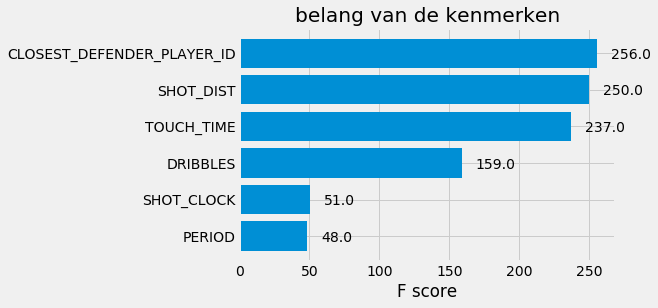

In [81]:
importances = forest.feature_importances_
indices = np.argsort(importances)
fig, ax = plt.subplots()
y_pos = np.arange(len(features))
                  
ax.barh(range(len(indices)), importances[indices] * 1000, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.set_xlabel('F score')
ax.set_title('belang van de kenmerken')
for i, v in enumerate(importances[indices]*1000):
    ax.text(v + 10, i - 0.15, round(v), color='black')
plt.show()

<h3>Gradient Boosten Trees (XGB)</h3>

In [88]:
# tutorial over voorspelling met XGB
# : https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
# VOOR XGB BOOST TE INSTALLEREN : https://www.ibm.com/developerworks/community/blogs/jfp/entry/Installing_XGBoost_For_Anaconda_on_Windows?lang=en
# ZONDER XGB BOOST RUNT DEZE CODE NIET!!!
df_xgb = df[['PERIOD', 'SHOT_CLOCK','DRIBBLES','TOUCH_TIME','SHOT_DIST','CLOSE_DEF_DIST','FGM']]
X = df_xgb.iloc[:,0:6]
Y = df_xgb.iloc[:,6]

# split data into train and test sets
seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
actuals = y_test

confusion_tabel = pd.crosstab(index=y_test, columns=y_pred, rownames=['actual'], colnames=['preds'])
accuracy_XGB = accuracy_score(y_test, predictions)

print(confusion_tabel)
print(" ")
print("Hoeveel % van de voorspellingen waren correct?")
print("De accuracy bedraagt: ",round(accuracy_XGB * 100.0, 2), "%")

preds       0     1
actual             
0       14034  2223
1        9195  4395
 
Hoeveel % van de voorspellingen waren correct?
De accuracy bedraagt:  61.74 %


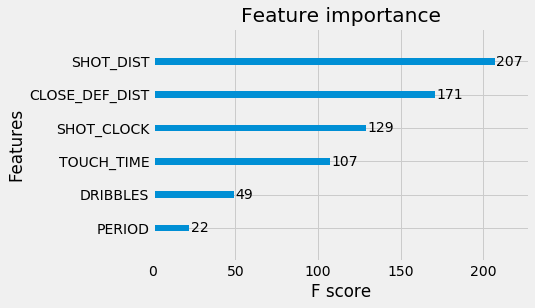

In [89]:
model = XGBClassifier()
model.fit(X,Y)
plot_importance(model, importance_type ='weight')
plt.show()

In [90]:
acc = [("accuracy RFC model", [accuracy_RFC]),
               ("accuracy XGB model", [round(accuracy_XGB * 100.0, 2)])
              ]
df_accuracy = pd.DataFrame.from_items(acc)
df_accuracy


,accuracy RFC model,accuracy XGB model
0,58.51,61.74
